In [71]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import glob
from datetime import timedelta

In [72]:
# Step 1: Load and Clean Each Dataset
def load_and_clean_data(file_path):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values('Date')
    
    # Create features
    data['MA7'] = data['Close'].rolling(window=7).mean()
    data['MA30'] = data['Close'].rolling(window=30).mean()
    data['Daily Return'] = data['Close'].pct_change()
    data['Lag1'] = data['Close'].shift(1)
    data['Lag7'] = data['Close'].shift(7)
    data['Lag30'] = data['Close'].shift(30)
    
    # Drop rows with NaN values
    data = data.dropna()
    
    return data

In [73]:
# List of file paths for your datasets
file_paths = glob.glob('E:\Machine Learning\Crypto Price Prediction\Datasets\*.csv')

# Step 2: Load and clean each dataset
datasets = [load_and_clean_data(file_path) for file_path in file_paths]

In [74]:
# Print the shape of each cleaned dataset
for i, dataset in enumerate(datasets):
    print(f"Dataset {i+1} shape after cleaning: {dataset.shape}")

Dataset 1 shape after cleaning: (245, 16)
Dataset 2 shape after cleaning: (1412, 16)
Dataset 3 shape after cleaning: (2961, 16)
Dataset 4 shape after cleaning: (1344, 16)
Dataset 5 shape after cleaning: (1355, 16)
Dataset 6 shape after cleaning: (815, 16)
Dataset 7 shape after cleaning: (905, 16)
Dataset 8 shape after cleaning: (2730, 16)
Dataset 9 shape after cleaning: (1436, 16)
Dataset 10 shape after cleaning: (2130, 16)
Dataset 11 shape after cleaning: (1454, 16)
Dataset 12 shape after cleaning: (2961, 16)
Dataset 13 shape after cleaning: (2572, 16)
Dataset 14 shape after cleaning: (2258, 16)
Dataset 15 shape after cleaning: (290, 16)
Dataset 16 shape after cleaning: (422, 16)
Dataset 17 shape after cleaning: (2497, 16)
Dataset 18 shape after cleaning: (2288, 16)
Dataset 19 shape after cleaning: (1362, 16)
Dataset 20 shape after cleaning: (262, 16)
Dataset 21 shape after cleaning: (972, 16)
Dataset 22 shape after cleaning: (858, 16)
Dataset 23 shape after cleaning: (2863, 16)


In [75]:
# Step 3: Combine Datasets
combined_data = pd.concat(datasets, ignore_index=True)
print(f"Combined dataset shape: {combined_data.shape}")

Combined dataset shape: (36392, 16)


In [76]:
# Step 4: Normalize/Scale Features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA30', 'Daily Return', 'Lag1', 'Lag7', 'Lag30']
scaler = MinMaxScaler()
combined_data[features] = scaler.fit_transform(combined_data[features])

In [77]:
# Print the first few rows of the combined and normalized data
print("First few rows of the combined and normalized data:")
print(combined_data.head())

First few rows of the combined and normalized data:
   SNo  Name Symbol                Date      High       Low      Open  \
0   31  Aave   AAVE 2020-11-04 23:59:59  0.000438  0.000419  0.000441   
1   32  Aave   AAVE 2020-11-05 23:59:59  0.000498  0.000417  0.000436   
2   33  Aave   AAVE 2020-11-06 23:59:59  0.000629  0.000496  0.000487   
3   34  Aave   AAVE 2020-11-07 23:59:59  0.000793  0.000618  0.000605   
4   35  Aave   AAVE 2020-11-08 23:59:59  0.000845  0.000689  0.000702   

      Close    Volume     Marketcap       MA7      MA30  Daily Return  \
0  0.000436  0.000144  3.130213e+08  0.000477  0.000665      0.111652   
1  0.000487  0.000243  3.502055e+08  0.000481  0.000658      0.143678   
2  0.000606  0.000420  4.358764e+08  0.000498  0.000658      0.174910   
3  0.000702  0.000572  5.077072e+08  0.000532  0.000658      0.154368   
4  0.000846  0.000498  6.130149e+08  0.000586  0.000662      0.165614   

       Lag1      Lag7     Lag30  
0  0.000442  0.000510  0.000838  
1 

In [78]:
# Step 5: Split Data into Training and Testing Sets
X = combined_data[features]
y = combined_data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [79]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize GridSearchCV
regressor = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit the grid search to the data
regressor.fit(X_train, y_train)

# Extract the best model
best_model = regressor.best_estimator_


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


Mean Squared Error: 0.00026125059061937636


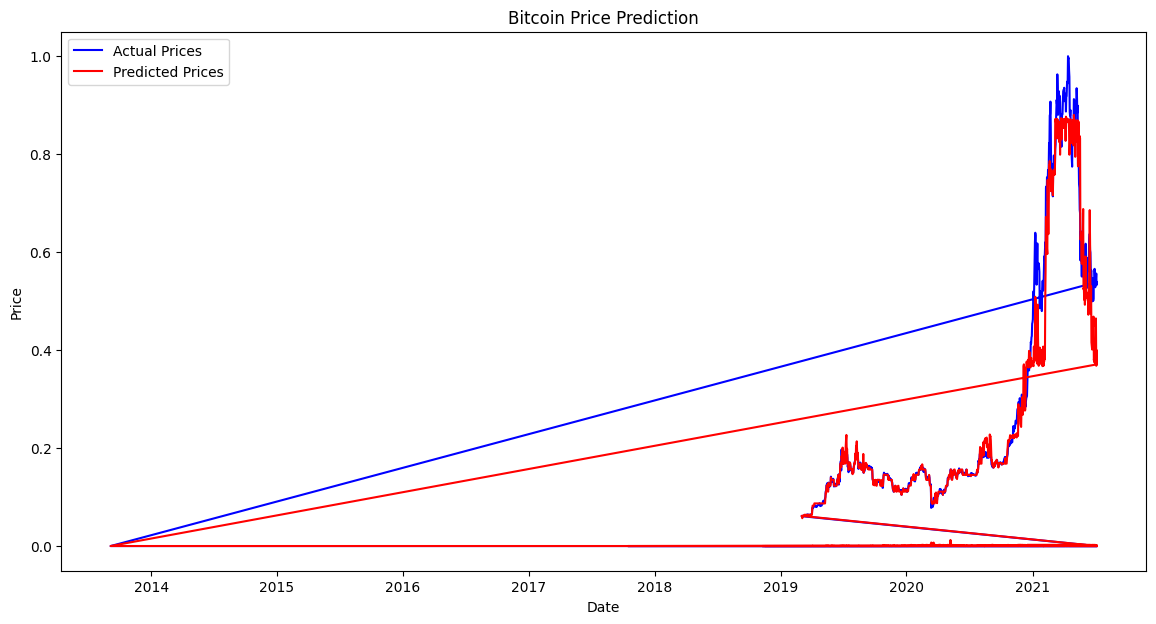

In [80]:
# Step 7: Predict Prices
y_pred = best_model.predict(X_test)

# Step 8: Evaluate Models
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Step 9: Visualize Results
plt.figure(figsize=(14, 7))
plt.plot(combined_data['Date'].iloc[len(X_train):].values, y_test, color='blue', label='Actual Prices')
plt.plot(combined_data['Date'].iloc[len(X_train):].values, y_pred, color='red', label='Predicted Prices')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

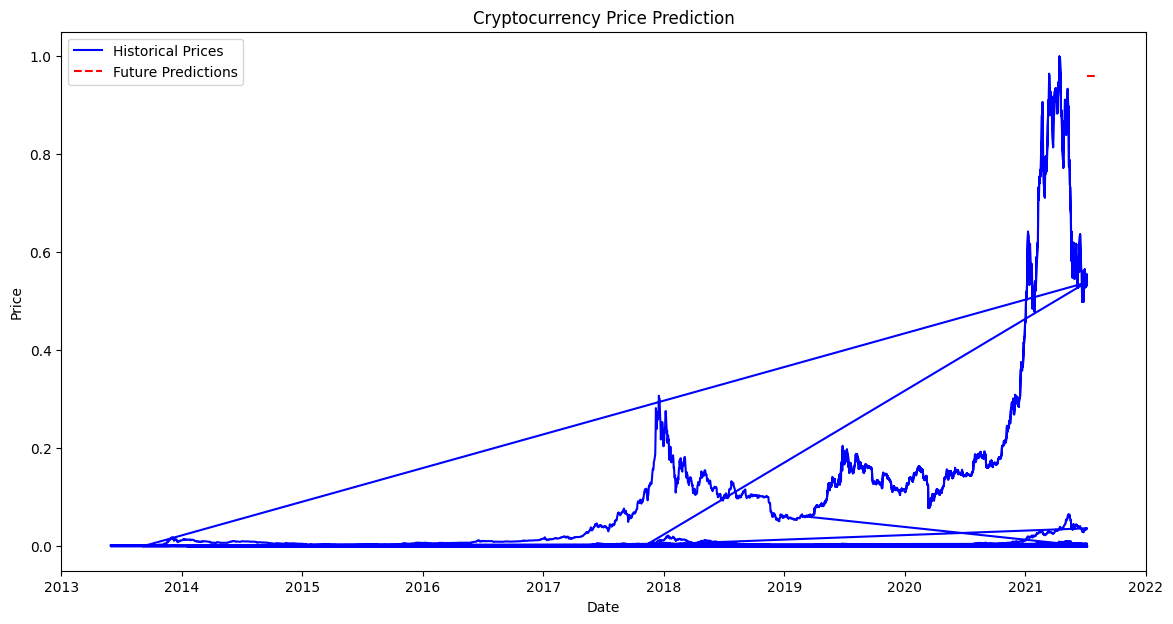

In [81]:
# Prepare future dates and predict future prices
def prepare_future_features(last_data, num_days):
    future_dates = pd.date_range(start=last_data['Date'].max() + timedelta(days=1), 
                                 periods=num_days, freq='D')
    future_data = pd.DataFrame({
        'Date': future_dates
    })
    future_data = pd.merge(future_data, last_data, on='Date', how='left')
    
    for i in range(1, 31):
        future_data[f'Lag{i}'] = future_data['Close'].shift(i)
    
    future_data['MA7'] = future_data['Close'].rolling(window=7).mean()
    future_data['MA30'] = future_data['Close'].rolling(window=30).mean()
    future_data['Daily Return'] = future_data['Close'].pct_change()
    
    return future_data[features].fillna(method='bfill').fillna(method='ffill')

# Generate future predictions
future_features = prepare_future_features(combined_data, num_days=30)
future_predictions = best_model.predict(future_features)

# Combine the future predictions with dates
future_dates = pd.date_range(start=combined_data['Date'].max() + timedelta(days=1), periods=30, freq='D')
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions
})

# Visualize the predictions
plt.figure(figsize=(14, 7))
plt.plot(combined_data['Date'], combined_data['Close'], color='blue', label='Historical Prices')
plt.plot(future_df['Date'], future_df['Predicted Price'], color='red', linestyle='--', label='Future Predictions')
plt.title('Cryptocurrency Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()